In [11]:
%matplotlib inline
from qiskit import IBMQ, execute
from qiskit.pulse import Schedule, MeasureChannel, DriveChannel, AcquireChannel, MemorySlot, Play, GaussianSquare, Acquire, Gaussian
from qiskit.pulse.macros import measure_all, measure
from qiskit.test.mock import FakeAlmaden
from qiskit.visualization import plot_histogram
from qiskit.tools import job_monitor

backend = FakeAlmaden()
try:
    backend = IBMQ.load_account().get_backend(open_pulse=True)
    config = backend.configuration()
    props = backend.properties()
    defaults = backend.defaults()
    print_basic_information(config)
    describe_qubit(0, props)
    print_channel_information(defaults)
    
    
except:
    print("No internet")
    
def run(s, b):
    job = execute(s, b)
    job_monitor(job)
    return job.result().get_counts()

def print_basic_information(c):
    print("This backend is called {0}, and is on version {1}. It has {2} qubit{3}. It {4} OpenPulse programs. The basis gates supported on this device are {5}.".format(c.backend_name, c.backend_version, c.n_qubits, '' if c.n_qubits == 1 else 's', 'supports' if c.open_pulse else 'does not support', c.basis_gates))

def print_channel_information(d):
    q0_freq = d.qubit_freq_est[0]  # Hz
    q0_meas_freq = d.meas_freq_est[0]  # Hz

    GHz = 1e-9
    print("DriveChannel(0) defaults to a modulation frequency of {} GHz.".format(q0_freq * GHz))
    print("MeasureChannel(0) defaults to a modulation frequency of {} GHz.".format(q0_meas_freq * GHz))
    calibrations = defaults.instruction_schedule_map

def describe_qubit(qubit, properties):
    """Print a string describing some of reported properties of the given qubit."""

    # Conversion factors from standard SI units
    us = 1e6
    ns = 1e9
    GHz = 1e-9

    print("Qubit {0} has a \n"
          "  - T1 time of {1} microseconds\n"
          "  - T2 time of {2} microseconds\n"
          "  - U2 gate error of {3}\n"
          "  - U2 gate duration of {4} nanoseconds\n"
          "  - resonant frequency of {5} GHz".format(
              qubit,
              properties.t1(qubit) * us,
              properties.t2(qubit) * us,
              properties.gate_error('u2', qubit),
              properties.gate_length('u2', qubit) * ns,
              properties.frequency(qubit) * GHz))

def get_custom_measurement():
    # Duration (in number of cycles) for readout 
    duration = 1600
    # Stimulus pulses for qubit 0
    measure_tx = Play(GaussianSquare(duration=duration, amp=0.2, sigma=10, width=duration - 50), MeasureChannel(0))
    measure_rx = Acquire(duration, AcquireChannel(0), MemorySlot(0))
    measure_sched = measure_tx + measure_rx
    return measure_sched

ibmqfactory.load_account:WARNING:2020-10-26 19:24:50,774: Credentials are already in use. The existing account in the session will be replaced.


This backend is called ibmq_armonk, and is on version 1.1.1. It has 1 qubit. It supports OpenPulse programs. The basis gates supported on this device are ['id', 'u1', 'u2', 'u3'].
Qubit 0 has a 
  - T1 time of 125.8657267702486 microseconds
  - T2 time of 186.56566932849455 microseconds
  - U2 gate error of 0.0007046344056486491
  - U2 gate duration of 142.22222222222223 nanoseconds
  - resonant frequency of 4.974445734150876 GHz
DriveChannel(0) defaults to a modulation frequency of 4.974445734150876 GHz.
MeasureChannel(0) defaults to a modulation frequency of 6.993427855 GHz.


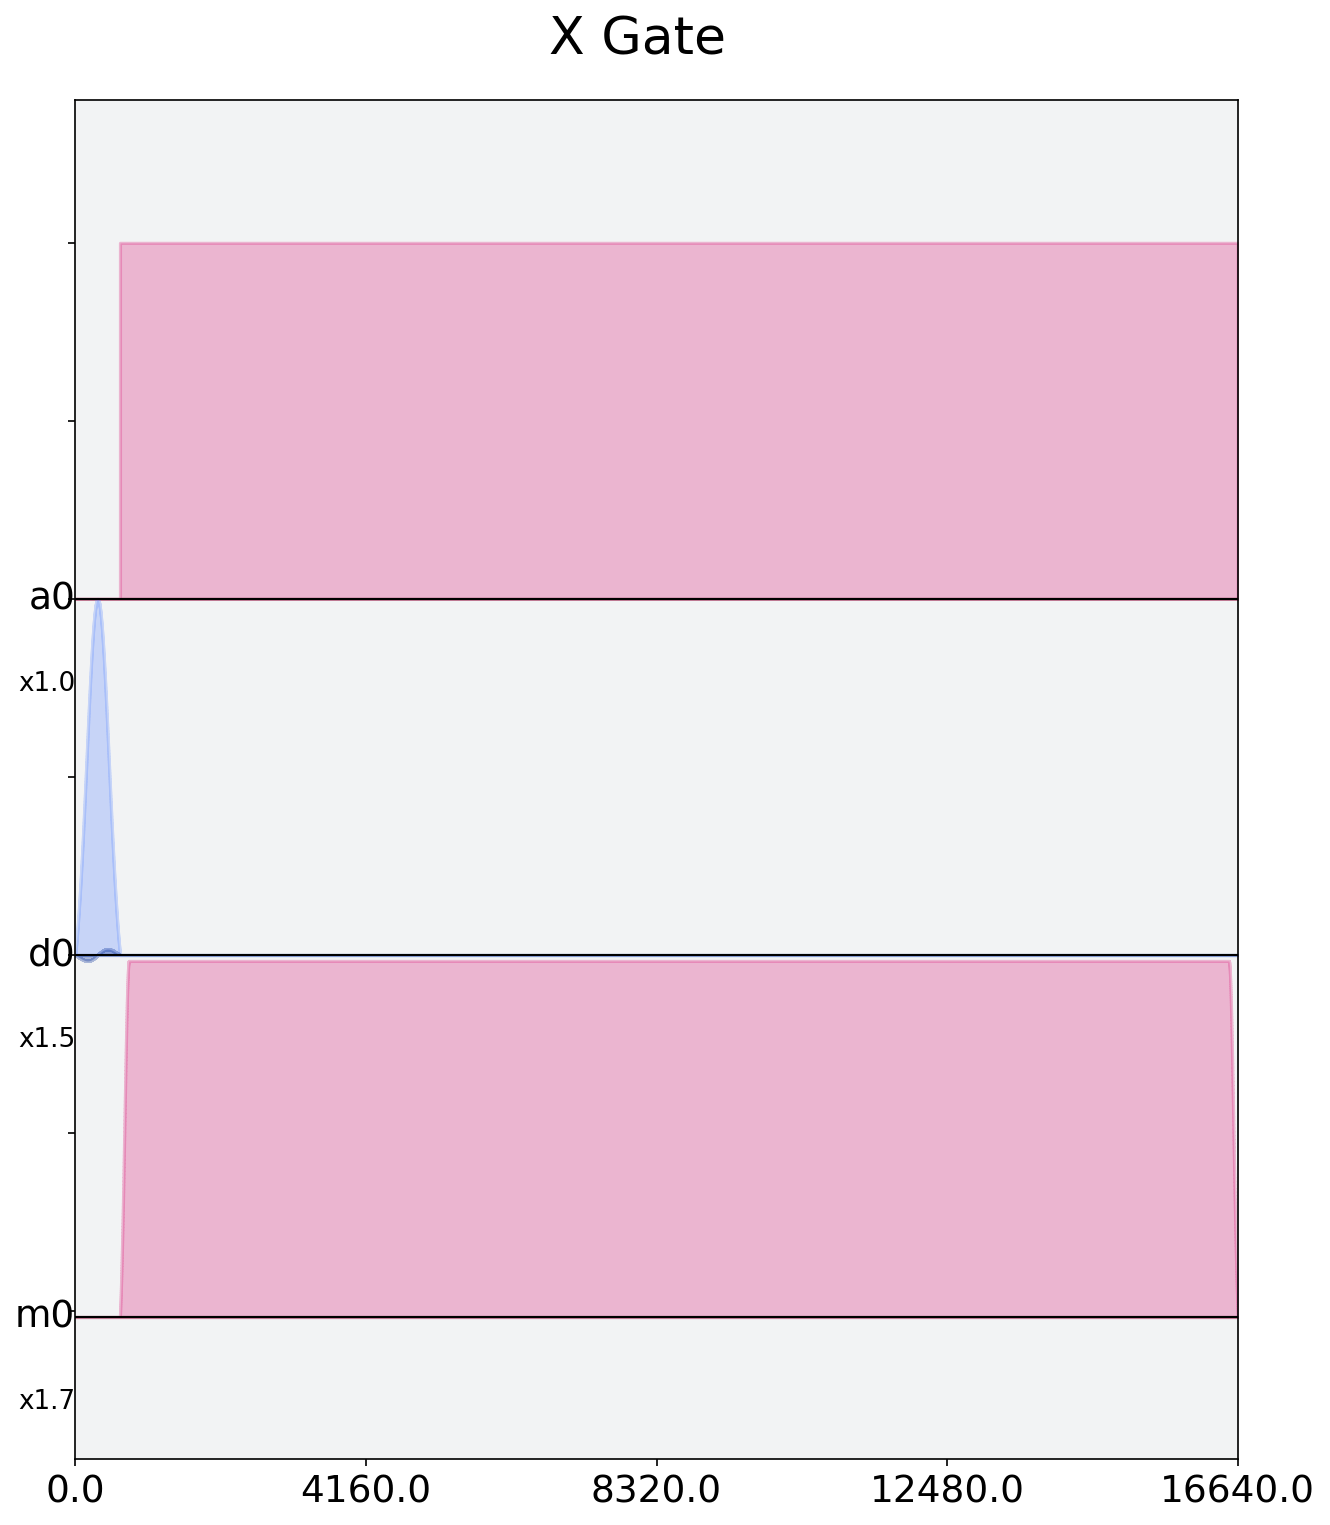

In [18]:
channel = DriveChannel(0)
sched = Schedule(name="X Gate")

x_sched = calibrations.get('x', 0)

sched |= x_sched
sched |= measure_all(backend) << sched.duration
sched.draw()

Job Status: job has successfully run


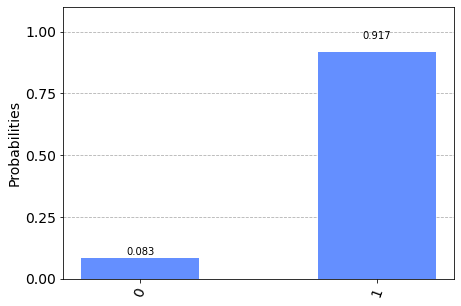

In [19]:
plot_histogram(run(sched, backend))